In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
cd drive/My\ Drive

[Errno 2] No such file or directory: 'drive/My Drive'
/content/drive/My Drive


In [0]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [10]:
pip install bindsnet

In [11]:
pip install easydict

In [0]:
import os
import numpy as np
import torch
import torch.nn as nn
import argparse
import matplotlib.pyplot as plt

from torchvision import transforms
from tqdm import tqdm_notebook as tqdm
from bindsnet.analysis.plotting import (
    plot_input,
    plot_spikes,
    plot_voltages,
    plot_weights,
)
from bindsnet.datasets import MNIST
from bindsnet.encoding import PoissonEncoder
from bindsnet.network import Network
from bindsnet.network.nodes import Input

# Build a simple two-layer, input-output network.
from bindsnet.network.monitors import Monitor
from bindsnet.network.nodes import LIFNodes
from bindsnet.network.topology import Connection
from bindsnet.utils import get_square_weights

import easydict

In [19]:
args = easydict.EasyDict({
        "seed": 0,
        "n_neurons": 500,
        "n_epochs": 100,
        "n_examples": 100,
        "n_workers": -1,
        "time": 251,
        "dt": 1.0,
        "intensity": 64,
        "progress_interval": 10,
        "update_interval": 250,
        "gpu": True,
        "device_id": 0,
        "train": True
})

#parser = argparse.ArgumentParser()
#parser.add_argument("--seed", type=int, default=0)
#parser.add_argument("--n_neurons", type=int, default=500)
#parser.add_argument("--n_epochs", type=int, default=100)
#parser.add_argument("--examples", type=int, default=500)
#parser.add_argument("--n_workers", type=int, default=-1)
#parser.add_argument("--time", type=int, default=250)
#parser.add_argument("--dt", type=int, default=1.0)
#parser.add_argument("--intensity", type=float, default=64)
#parser.add_argument("--progress_interval", type=int, default=10)
#parser.add_argument("--update_interval", type=int, default=250)
#parser.add_argument("--plot", dest="plot", action="store_true")
#parser.add_argument("--gpu", dest="gpu", action="store_true")
#parser.add_argument("--device_id", type=int, default=0)
#parser.set_defaults(plot=True, gpu=False, train=True) 

#args = parser.parse_args()

seed = args.seed
n_neurons = args.n_neurons
n_epochs = args.n_epochs
n_examples = args.n_examples
n_workers = args.n_workers
time = args.time
dt = args.dt
intensity = args.intensity
progress_interval = args.progress_interval
update_interval = args.update_interval
train = args.train
gpu = args.gpu
device_id = args.device_id
n_iters = n_examples

np.random.seed(seed)
torch.cuda.manual_seed_all(seed)
torch.manual_seed(seed)

# Sets up Gpu use
if gpu and torch.cuda.is_available():
    torch.cuda.set_device(device_id)
    # torch.set_default_tensor_type('torch.cuda.FloatTensor')
else:
    torch.manual_seed(seed)

# dt: the simulation time step
network = Network(dt=dt)

# 入力層
inpt = Input(2, shape=(1,2))
network.add_layer(inpt, name="I")

# リザーバー層
output = LIFNodes(n_neurons, thresh=-52 + np.random.randn(n_neurons).astype(float))
network.add_layer(output, name="O")

# 入力層->リザーバー層とリザーバー層->リザーバー層のコネクションを作成
C1 = Connection(source=inpt, target=output, w=0.5 * torch.randn(inpt.n, output.n))
C2 = Connection(source=output, target=output, w=0.5 * torch.randn(output.n, output.n))
network.add_connection(C1, source="I", target="O")
network.add_connection(C2, source="O", target="O")

# スパイクのモニター(入力、リザーバー)
spikes = {}
for l in network.layers:
    spikes[l] = Monitor(network.layers[l], ["s"], time=time)
    network.add_monitor(spikes[l], name="%s_spikes" % l)

# ボルトのモニター(リザーバー)
voltages = {"O": Monitor(network.layers["O"], ["v"], time=time)}
network.add_monitor(voltages["O"], name="O_voltages")

# Directs network to GPU
if gpu:
    network.to("cuda")

# dataset作成
class MyDataset(torch.utils.data.Dataset):
    # xy.shape = (n, time, xy)
    # F.shape = (n, time, F)
    def __init__(self, xy, F, transform=None):
        self.transform = transform
        self.data_num = xy.shape[0]
        self.data = xy
        self.label = F

    def __len__(self):
        return self.data_num

    def __getitem__(self, idx):
        # q = int((bs-1)/2)
        out_data = self.data[idx]
        out_label =  self.label[idx]

        if self.transform:
            out_data = self.transform(out_data)

        return out_data, out_label

train_data = pd.read_csv("train_data.csv", header = None)
train_data = np.array(train_data)
train_data = train_data.reshape((1000,251,4))
# from IPython.core.debugger import Pdb; Pdb().set_trace()
xy = train_data[:,0:2]
F = train_data[:,2:4]
dataset = MyDataset(xy, F, transform=None)

# Create a dataloader to iterate and batch data
dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=1, shuffle=True, num_workers=0, pin_memory=gpu
)

# Run training data on reservoir computer and store (spikes per neuron, label) per example.
training_pairs = []
pbar = tqdm(enumerate(dataloader))

# from IPython.core.debugger import Pdb; Pdb().set_trace()
# このループではトレーニングデータを作成していると考えて良い
# q = int((bs-1)/2)
for (i, dataPoint) in pbar:
    # data, labelを取り出している
    datum = dataPoint[0].view(time, 2)
    labels = dataPoint[1].view(time, 2)
    pbar.set_description_str("Train progress: (%d / %d)" % (i, n_iters))

    for j in range(q, datum.shape[0]-q):
        data = datum[j].to(device_id)
        data = data[np.newaxis,np.newaxis,:,:]
        label = labels[j]
        # 時間を1つ進める
        network.run(inputs={"I": data}, time=1, input_time_dim=1)
        # リザーバー層の状態とラベルをトレーニングデータとして保存
        training_pairs.append([spikes["O"].get("s").sum(0), label])

    network.reset_state_variables()
np.save("training_pairs", training_pairs)
# Define logistic regression model using PyTorch.

# training_pairs = np.load("training_pairs.npy", allow_pickle=True)
# 回帰モデル
class NN(nn.Module):
    def __init__(self, input_size):
        super(NN, self).__init__()
        #h = int(input_size/2)
        # self.linear_1 = nn.Linear(input_size, num_classes)
        # self.linear_1 = nn.Linear(input_size, h)
        # self.linear_2 = nn.Linear(h, 2)
        self.linear = nn.Linear(input_size, 2)

    def forward(self, x):
        # out = torch.relu(self.linear_1(x.float().view(-1)))
        # out = self.linear_2(out)
        out = self.linear(x.float().view(-1))
        return out

# Create and train logistic regression model on reservoir outputs.
model = NN(n_neurons).to(device_id)
criterion = torch.nn.MSELoss(reduction="sum")
# optimizer = torch.optim.SGD(model.parameters(), lr=1e-4, momentum=0.9)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, betas=(0.9, 0.999))

# Training the Model
# 回帰モデルを先ほど生成したデータでトレーニング
print("\n Training the read out")
# model.load_state_dict(torch.load("model"))
pbar = tqdm(enumerate(range(n_epochs)))
for epoch, _ in pbar:
    avg_loss = 0
    for i, (s, l) in enumerate(training_pairs):
        # Forward + Backward + Optimize
        optimizer.zero_grad()
        outputs = model(s.view(-1))
        label = l.float().to(device_id)
        loss = criterion(outputs, label)
        avg_loss += loss.data
        loss.backward()
        optimizer.step()
    pbar.set_description_str(
        "Epoch: %d/%d, Loss: %.4f"
        % (epoch + 1, n_epochs, avg_loss / len(training_pairs))
    )

torch.save(model.state_dict(), "model")

test_pairs = []
pbar = tqdm(enumerate(dataloader))
for (i, dataPoint) in pbar:
    datum = dataPoint[0].view(time, 2)
    labels = dataPoint[1].view(time, 2)
    pbar.set_description_str("Testing progress: (%d / %d)" % (i, n_iters))

    for j in range(q, datum.shape[0]-q):
        data = datum[ j-q : j+q+1 ].to(device_id)
        data = data[np.newaxis,np.newaxis,:,:]
        label = labels[j]
        # 時間を1つ進める
        network.run(inputs={"I": data}, time=1, input_time_dim=1)
        # リザーバー層の状態とラベルをトレーニングデータとして保存
        test_pairs.append([spikes["O"].get("s").sum(0), label])

    network.reset_state_variables()

np.save("test_pairs", test_pairs)

# test_pairs = np.load("test_pairs.npy", allow_pickle=True)

# Test the Model
# 作成したテストデータでロジスティック回帰モデルをテスト
loss, total = 0, 0
for s, label in test_pairs:
    outputs = model(s)
    loss += criterion(outputs, label.float().to(device_id)).data
    total += 1

print(
    "\n Accuracy of the model on %d test images: %.2f %%"
    % (n_iters, loss / total)
)

RuntimeError: ignored

In [0]:
np.array(training_pairs).shape

(29600, 2)

In [0]:
np.save("training_pairs", training_pairs)
np.save("test_pairs", test_pairs)

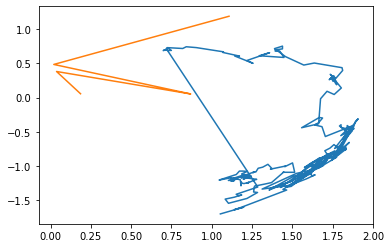

In [0]:
n = 100
test_pairs_ = test_pairs[296*n:296*(n+1)]
theta1 = []
theta2 = []
true_theta1 = []
true_theta2 = []
for s, label in test_pairs_:
    theta1.append(model(s)[0])
    theta2.append(model(s)[1])
    true_theta1.append(label[0])
    true_theta2.append(label[1])
x_, y_ = theta_to_xy(theta1,theta2)
true_x, true_y = theta_to_xy(true_theta1, true_theta2)
plt.plot(x_,y_)
plt.plot(true_x, true_y)